<a href="https://colab.research.google.com/github/vikrantmehta123/dl-for-coders-workbook/blob/main/MNIST_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Digit Recognition Model

In this notebook, we'll train a deep learning model to classify handwritten digits from 0 to 9. We'll use the MNIST dataset for the purposes of training, and we'll use FastAI and PyTorch to implement our model. This notebook is implemented as an exercise for FastAI's course on deep learning: "Deep Learning for Coders".

In [4]:
# installation and setup of the Fast AI notebook
! [ -e /content ] && pip install -Uqq fastbook;
import fastbook;

In [5]:
# Import necessary libraries and configs
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

### Getting the Data:

The MNIST dataset is available in the FastAI library in the `URLs`  module and we can use `untar_data` to get the paths for the dataset. We get a training directory and a testing directory. Inside these, there are subdirectories for each of the digits.



In [6]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [7]:
# This line is directly from FastAI's notebooks
Path.BASE_PATH = path

In [8]:
training_path = (path/'training').ls()
training_path

(#10) [Path('training/0'),Path('training/6'),Path('training/8'),Path('training/2'),Path('training/7'),Path('training/9'),Path('training/3'),Path('training/1'),Path('training/4'),Path('training/5')]

### Plotting Samples:

Now that we know how to access the data, let's plot a digit from each of the subdirectories. We'll use `subplots` function from `matplotlib` to plot the digits in a single plot.

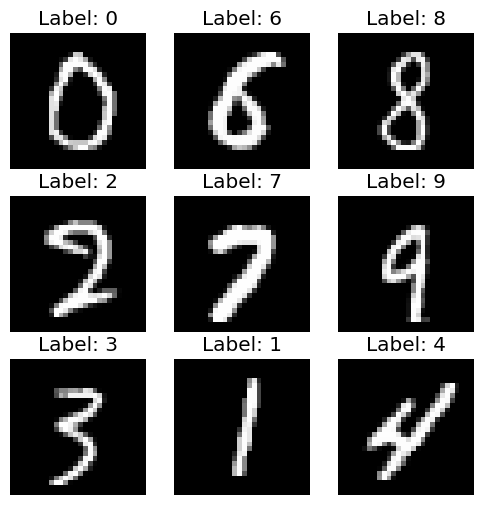

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i in range(9):
    img = Image.open(training_path[i].ls()[0])
    img_tensor = tensor(img)
    img_label = str(training_path[i])[-1]
    ax = axes[i // 3, i % 3]  # Determine position in grid
    ax.imshow(img_tensor, cmap='gray')  # Plot the image in grayscale
    ax.set_title(f'Label: {img_label}')  # Set the title as the label
    ax.axis('off')  # Turn off the axis

### Creating the Training Dataset:

For this data to be usable, we need to first open all the images and get their tensor representations. We'll stack these tensor representations in a list. We'll also create the labels for the training data using the directory name as the label.

To standardize the data, we're dividing all tensors by 255 such that the values fall between 0 to 1.

In [10]:
x = [ ] # list of tensor representations of images
y = [ ] # list of output labels
for i in range(10):
    img_paths = (path/'training'/str(i)).ls()  # Get the image paths in folder 'i'

    # Load the images and convert to tensors

    x.extend([tensor(Image.open(o)) for o in img_paths])

    # Store the corresponding label `i` for all images in this folder
    y.extend([tensor(i)] * len(img_paths))

In [11]:
# Convert the python list into PyTorch tensor so that we can use these in model, and standardize it
x_tensor = torch.stack(x).float()/255
y_tensor = torch.tensor(y)

x_tensor.shape, y_tensor.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [12]:
# Each image is 28 * 28. We flatten each image into a single tensor of size 784.
flattened_x = x_tensor.view(-1, 28*28)
flattened_y = y_tensor.unsqueeze(1) # y_tensor has shape [60000], we unsqueeze it to make it [60000, 1]
flattened_x.shape, flattened_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

### Splitting the Dataset:

Now that we have created a dataset that can be passed to our model, let's split the data into a training and a validation set. For this model, we are use `RandomSplitter` from FastAI to split the dataset randomly into training and validation sets. `RandomSplitter` gives us indices for the training and validation sets, which we can use to split the dataset.


In [13]:
from fastai.data.transforms import RandomSplitter

splitter = RandomSplitter(valid_pct=0.2, seed=42)  # 80% training, 20% validation

train_idxs, val_idxs = splitter(range(len(flattened_x)))

# Create the training and validation data using indexing
X_train = flattened_x[train_idxs]
y_train = flattened_y[train_idxs]

X_val = flattened_x[val_idxs]
y_val = flattened_y[val_idxs]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([48000, 784]),
 torch.Size([48000, 1]),
 torch.Size([12000, 784]),
 torch.Size([12000, 1]))

In [14]:
# zip the inputs and output labels together to create datasets for training and validation
train_dataset = list(zip(X_train, y_train))
validation_dataset = list(zip(X_train, y_train))

We define some functions that we'll use throughout the notebook- for initializing random parameters, for computing cross-entropy loss, and for doing linear operations.

In [15]:
# randomly initialize parameters
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

# Linear operation of x_batch @ weights + bias
def linear(xb, weights, bias):
    return xb @ weights + bias


# log_softmax implementation
def log_softmax(logits):
    max_logits = logits.max(dim=1, keepdim=True).values
    stable_logits = logits - max_logits  # For numerical stability

    # Compute log-softmax
    log_probs = stable_logits - torch.log(torch.exp(stable_logits).sum(dim=1, keepdim=True))

    return log_probs

# Computation of cross entropy loss
def cross_entropy_loss(log_probs, yb):
    yb = yb.squeeze(1)
    log_probs = log_probs.squeeze(1)

    true_class_log_probs = log_probs[range(len(yb)), yb]

    loss = -true_class_log_probs.mean()
    return loss

### Building the Model:

For starters, we build a model that has a single layer in the network. The size of the weights is $784 \times 10$ and that of bias is $1 \times 10$.

In [16]:
weights = init_params((28*28,10))
bias = init_params((1, 10))

weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([1, 10]))

In [17]:
# Convert the training and validation datasets into dataloaders
# because dataloaders will take care of passing the inputs in batches for us.
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=True)

##### Train the Model

Now that we've defined the architecture for the model, let's train it. We'll train it for 25 epochs and us a learning rate of 0.01

In [18]:
epochs = 25
learning_rate = 0.01
for i in range(epochs):
    for xb, yb in train_dataloader:
        # Zero the gradients for the next batch
        if weights.grad is not None:
            weights.grad.zero_()
        if bias.grad is not None:
            bias.grad.zero_()

        # Compute the log softmax probabilities
        probabilities = log_softmax(linear(xb, weights, bias))

        # Based on the predictions compute loss
        loss = cross_entropy_loss(probabilities, yb)
        loss.backward()

        # Update weights and biases
        with torch.no_grad():
            weights -= learning_rate * weights
            bias -= learning_rate * bias.grad

    epoch_loss = 0
    for xb, yb in validation_dataloader:
        probabilities = log_softmax(linear(xb, weights, bias))
        loss = cross_entropy_loss(probabilities, yb)
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(validation_dataloader)

    # Print the loss after each epoch
    print(f'Epoch [{i+1}/{epochs}], Loss: {average_loss:.4f}')


Epoch [1/25], Loss: 3.5902
Epoch [2/25], Loss: 2.7104
Epoch [3/25], Loss: 2.5614
Epoch [4/25], Loss: 2.4830
Epoch [5/25], Loss: 2.4322
Epoch [6/25], Loss: 2.3971
Epoch [7/25], Loss: 2.3722
Epoch [8/25], Loss: 2.3537
Epoch [9/25], Loss: 2.3402
Epoch [10/25], Loss: 2.3300
Epoch [11/25], Loss: 2.3224
Epoch [12/25], Loss: 2.3168
Epoch [13/25], Loss: 2.3126
Epoch [14/25], Loss: 2.3094
Epoch [15/25], Loss: 2.3071
Epoch [16/25], Loss: 2.3054
Epoch [17/25], Loss: 2.3042
Epoch [18/25], Loss: 2.3033
Epoch [19/25], Loss: 2.3026
Epoch [20/25], Loss: 2.3022
Epoch [21/25], Loss: 2.3019
Epoch [22/25], Loss: 2.3016
Epoch [23/25], Loss: 2.3014
Epoch [24/25], Loss: 2.3013
Epoch [25/25], Loss: 2.3012


### Model Evaluation

We've now trained our model. Now let's see if we can use this model to predict the labels for the test dataset.

In [19]:
testing_path = (path/'testing').ls()
testing_path

(#10) [Path('testing/0'),Path('testing/6'),Path('testing/8'),Path('testing/2'),Path('testing/7'),Path('testing/9'),Path('testing/3'),Path('testing/1'),Path('testing/4'),Path('testing/5')]

We fetch the test dataset from the `testing` directory and apply the same transformations we applied to the training dataset- flattening and standardizing it.

In [20]:
x_test = [ ]
y_test = [ ]
for i in range(10):
    img_paths = (path/'testing'/str(i)).ls()  # Get the image paths in folder 'i'

    # Load the images and convert to tensors

    x_test.extend([tensor(Image.open(o)) for o in img_paths])

    # Store the corresponding label `i` for all images in this folder
    y_test.extend([tensor(i)] * len(img_paths))


x_test_tensor = torch.stack(x_test).float()/255
y_test_tensor = torch.tensor(y_test)

# Each image is 28 * 28. So we flatten each image into a single flat tensor of size 784.
flattened_x_test = x_test_tensor.view(-1, 28*28)
flattened_y_test = y_test_tensor.unsqueeze(1)
flattened_x_test.shape, flattened_y_test.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

##### Predict

We use the transformed test dataset and the model that we trained to predict on the test dataset, and compute the accuracy of our predictions.

In [21]:
# Forward pass through the network
logits = linear(flattened_x_test, weights, bias)  # Get logits
probabilities = torch.exp(log_softmax(logits))  # Get probabilities

predicted_classes = torch.argmax(probabilities, dim=1)

predicted_classes.shape

torch.Size([10000])

In [22]:
# Calculate the number of correct predictions

correct_predictions = (predicted_classes == y_test_tensor).sum().item()

# Calculate the number of incorrect predictions
incorrect_predictions = len(y_test_tensor) - correct_predictions

# Print the results
print(f'Number of correct predictions: {correct_predictions}')
print(f'Number of incorrect predictions: {incorrect_predictions}')

Number of correct predictions: 1135
Number of incorrect predictions: 8865


### Improving Model

The model gave only 10% accuracy. But not to worry! We have built the full model pipeline, let's see if we can improve the model further. We'll modify the architecture of the model and train the model a bit longer as well.

Here, we are training a two-layered model. It has the following components:

1. Linear layer
2. ReLU activation
3. Linear Layers
4. Softmax output function



In [23]:
# Initialize the weights and biases of the new architecture
w1 = init_params((28*28,128))
b1 = init_params(128)
w2 = init_params((128,10))
b2 = init_params(10)


epochs = 100
learning_rate = 0.01

for i in range(epochs):
    for xb, yb in train_dataloader:
        # Reset gradients
        if w1.grad is not None:
            w1.grad.zero_()
        if b1.grad is not None:
            b1.grad.zero_()
        if w2.grad is not None:
            w2.grad.zero_()
        if b2.grad is not None:
            b2.grad.zero_()

        # Forward pass
        hidden = torch.relu(linear(xb, w1, b1))
        probabilities = log_softmax(linear(hidden, w2, b2))

        # Compute loss
        loss = cross_entropy_loss(probabilities, yb)

        # Backpropagation
        loss.backward()

        # Update weights and biases
        with torch.no_grad():
            w1 -= learning_rate * w1.grad
            b1 -= learning_rate * b1.grad
            w2 -= learning_rate * w2.grad
            b2 -= learning_rate * b2.grad

    # Validation step- compute loss on vaidation dataset
    epoch_loss = 0
    for xb, yb in validation_dataloader:
        hidden = torch.relu(linear(xb, w1, b1))
        probabilities = log_softmax(linear(hidden, w2, b2))
        loss = cross_entropy_loss(probabilities, yb)
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(validation_dataloader)

    # Print the loss after each epoch
    print(f'Epoch [{i+1}/{epochs}], Loss: {average_loss:.4f}')


Epoch [1/100], Loss: 13.6687
Epoch [2/100], Loss: 8.8129
Epoch [3/100], Loss: 6.9474
Epoch [4/100], Loss: 5.9257
Epoch [5/100], Loss: 5.2786
Epoch [6/100], Loss: 4.7670
Epoch [7/100], Loss: 4.3802
Epoch [8/100], Loss: 4.0817
Epoch [9/100], Loss: 3.8078
Epoch [10/100], Loss: 3.5781
Epoch [11/100], Loss: 3.3970
Epoch [12/100], Loss: 3.2094
Epoch [13/100], Loss: 3.0610
Epoch [14/100], Loss: 2.9064
Epoch [15/100], Loss: 2.7894
Epoch [16/100], Loss: 2.6695
Epoch [17/100], Loss: 2.5793
Epoch [18/100], Loss: 2.4714
Epoch [19/100], Loss: 2.3799
Epoch [20/100], Loss: 2.2986
Epoch [21/100], Loss: 2.2194
Epoch [22/100], Loss: 2.1517
Epoch [23/100], Loss: 2.0960
Epoch [24/100], Loss: 2.0156
Epoch [25/100], Loss: 1.9566
Epoch [26/100], Loss: 1.9012
Epoch [27/100], Loss: 1.8587
Epoch [28/100], Loss: 1.7996
Epoch [29/100], Loss: 1.7487
Epoch [30/100], Loss: 1.7097
Epoch [31/100], Loss: 1.6657
Epoch [32/100], Loss: 1.6392
Epoch [33/100], Loss: 1.5850
Epoch [34/100], Loss: 1.5480
Epoch [35/100], Loss: 

Keep an eye on whether the validation loss starts increasing. This is an indication that our model is overfitting. We should stop training after that.

### Evaluating This Model

We repeat the same steps as before. Load the testing dataset, transform it like the training dataset and evaluate accuracy on this dataset.

In [24]:
x_test = [ ]
y_test = [ ]
for i in range(10):
    img_paths = (path/'testing'/str(i)).ls()  # Get the image paths in folder 'i'

    # Load the images and convert to tensors
    x_test.extend([tensor(Image.open(o)) for o in img_paths])

    # Store the corresponding label `i` for all images in this folder
    y_test.extend([tensor(i)] * len(img_paths))

x_test_tensor = torch.stack(x_test).float()/255
y_test_tensor = torch.tensor(y_test)

# Each image is 28 * 28. So we flatten each image into a single flat tensor of size 784.
flattened_x_test = x_test_tensor.view(-1, 28*28)
flattened_y_test = y_test_tensor.unsqueeze(1)

print(flattened_x_test.shape, flattened_y_test.shape)

# Forward pass through the network
hidden = torch.relu(linear(flattened_x_test, w1, b1))
probabilities = log_softmax(linear(hidden, w2, b2))

predicted_classes = torch.argmax(probabilities, dim=1)

predicted_classes.shape

torch.Size([10000, 784]) torch.Size([10000, 1])


torch.Size([10000])

In [25]:
# Calculate the number of correct predictions
correct_predictions = (predicted_classes == y_test_tensor).sum().item()

# Calculate the number of incorrect predictions
incorrect_predictions = len(y_test_tensor) - correct_predictions

# Print the results
print(f'Number of correct predictions: {correct_predictions}')
print(f'Number of incorrect predictions: {incorrect_predictions}')

Number of correct predictions: 9052
Number of incorrect predictions: 948


This is a great improvement on our previous model. We achieved an accuracy of 90.5%.

## Evaluating Model on Custom Images

We evaluated the model on the `testing` dataset. But what happens if pass custom hand-drawn digits to this model? Does the model perform well?

Let's test it. However, the images that we pass may not be in the same size as our model's inputs- for instance, in the cell below we are passing and image that is of shape $[292, 276]$. For this image to be loaded into our model, we need to reshape it. We need to apply some additional transforms to make this image fit into our desired shape.

Image shape:  (292, 276)


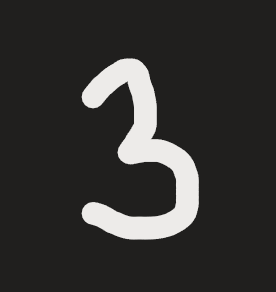

In [34]:
image = Image.open('/content/Screenshot 2024-10-23 212229.png')
print("Image shape: ", image.shape)
image

In [35]:
image = img.convert('L') # Convert image into greyscale
image.shape

(292, 276)

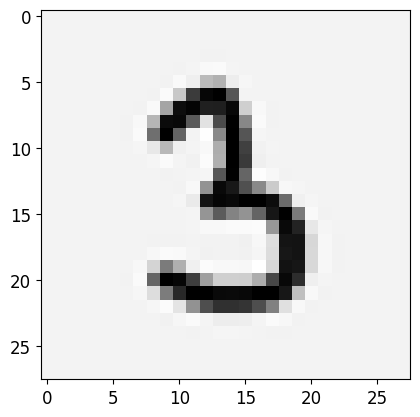

In [40]:
image = image.resize((28, 28), Image.LANCZOS) # Resize the image into 28*28 image using LANCZOS resizing

# plot the modified image
imgplot = plt.imshow(image)

In [41]:
# Standardize
image_array = np.array(image) / 255.0

# Add an extra dimension for batch. Now the shape is: [1, 28, 28]
image_array = image_array.reshape(1, 28, 28)
image_array.shape

(1, 28, 28)

In [42]:
# Convert the numpy image array into tensor and flatten it
img_tensor = tensor(image_array)
flattened_x_img_tensor = img_tensor.view(-1, 28*28)
flattened_x_img_tensor.shape

torch.Size([1, 784])

In [43]:
# Apply the model and predict
hidden = torch.relu(linear(flattened_x_img_tensor, w1, b1))
probabilities = log_softmax(linear(hidden, w2, b2))

predicted_class = torch.argmax(probabilities, dim=1)
predicted_class

tensor([3])

Yay! The model gave correct output for a new image as well. You can try to pass your own digits to check the output as well.